In [2]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
%matplotlib inline 
%precision 5

u'%.5f'

In [35]:
## Read in a mesh 
meshfile = open("pipe_mesh.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,3),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
print(node_X)
print(elements)

[[ 0.  0.]
 [ 0.  1.]
 [ 0.  3.]
 [ 0.  4.]
 [ 2.  0.]
 [ 1.  1.]
 [ 3.  2.]
 [ 2.  2.]
 [ 2.  4.]
 [ 1.  3.]]
[[ 1  6  2]
 [ 1  5  6]
 [ 5  8  6]
 [ 5  7  8]
 [ 7  9  8]
 [ 9 10  8]
 [ 9  4 10]
 [10  4  3]]


In [30]:
## To build the global stiffness matrix I need to have a function for the 
## gradient of shape functions

def Gradient_N1(x1,y1,x2,y2,x3,y3):
    
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN1dx = (1./(2*A_e))*(y2-y3)
    dN1dy = (1./(2*A_e))*(x3-x2)
    
    return np.array([dN1dx,dN1dy])

def Gradient_N2(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN2dx = (1./(2*A_e))*(y3-y1)
    dN2dy = (1./(2*A_e))*(x1-x3)
    
    return np.array([dN2dx,dN2dy])

def Gradient_N3(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN3dx = (1./(2*A_e))*(y1-y2)
    dN3dy = (1./(2*A_e))*(x2-x1)
    return np.array([dN3dx,dN3dy])

def Area(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    return A_e
    

In [31]:
## Build global stiffness
K = np.zeros((n_node,n_node))
## Loop over elements
for i in range(n_elem):
    # Get the nodes making up this element
    node1 = elements[i,0]-1 # the -1 is because indices start from 0
    node2 = elements[i,1]-1 # the -1 is because indices start from 0
    node3 = elements[i,2]-1 # the -1 is because indices start from 0
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    # Call function to evaluate the gradient of shape functions 
    GradN1e = Gradient_N1(x1,y1,x2,y2,x3,y3)
    GradN2e = Gradient_N2(x1,y1,x2,y2,x3,y3)
    GradN3e = Gradient_N3(x1,y1,x2,y2,x3,y3)
    # Build the element stiffness 
    A_e = Area(x1,y1,x2,y2,x3,y3)
    Ke = A_e*np.array([[np.dot(GradN1e,GradN1e),np.dot(GradN1e,GradN2e),np.dot(GradN1e,GradN3e)],
                   [np.dot(GradN2e,GradN1e),np.dot(GradN2e,GradN2e),np.dot(GradN2e,GradN3e)],
                   [np.dot(GradN3e,GradN1e),np.dot(GradN3e,GradN2e),np.dot(GradN3e,GradN3e)]])
    #print(Ke)
    # Assemble into the global stiffness 
    K[node1,node1] += Ke[0,0]
    K[node1,node2] += Ke[0,1]
    K[node1,node3] += Ke[0,2]
    K[node2,node1] += Ke[1,0]
    K[node2,node2] += Ke[1,1]
    K[node2,node3] += Ke[1,2]
    K[node3,node1] += Ke[2,0]
    K[node3,node2] += Ke[2,1]
    K[node3,node3] += Ke[2,2]

In [32]:
## Partition and solve
# solving the system with matrix partitioning, partion the K
n_E = 4
n_F = n_node-4
K_E = K[0:n_E,0:n_E]
K_F = K[n_E:,n_E:]
K_EF = K[0:n_E,n_E:]
print('K_E')
print(K_E)
print('K_F')
print(K_F)
print('K_EF')
print(K_EF)

K_E
[[ 1.  -0.5  0.   0. ]
 [-0.5  1.   0.   0. ]
 [ 0.   0.   1.  -0.5]
 [ 0.   0.  -0.5  1. ]]
K_F
[[ 1.25 -1.    0.   -0.25  0.    0.  ]
 [-1.    2.5   0.   -0.5   0.    0.  ]
 [ 0.    0.    2.   -2.    0.    0.  ]
 [-0.25 -0.5  -2.    3.5  -0.25 -0.5 ]
 [ 0.    0.    0.   -0.25  1.25 -1.  ]
 [ 0.    0.    0.   -0.5  -1.    2.5 ]]
K_EF
[[ 0.  -0.5  0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.   0.  -0.5]]


In [33]:
# known temperature
d_E = np.array([0.,0.,100.,100.])
# known external forces
F_F = np.zeros((n_F))
# solving A\b
d_F = np.linalg.solve(K_F,F_F- np.dot(K_EF.transpose(),d_E))
#print(d_F)
# Assemble into a single vector
d = np.zeros((n_node))
d[:n_E] = d_E
d[n_E:] = d_F
print(d)

[   0.         0.       100.       100.        26.47059   20.58824   50.
   50.        73.52941   79.41176]


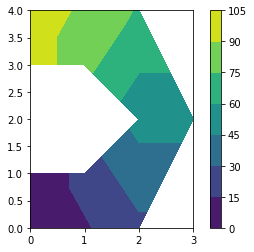

In [34]:
plt.figure()
plt.gca().set_aspect('equal')
plt.tricontourf(node_X[:,0],node_X[:,1] , elements-1, d)
plt.colorbar()